# **Integrated Data Science Workflows**

The primary objective of using **Generative AI Lab** is to train a high-quality, domain-specific Named Entity Recognition (NER) model.

This involves **multiple stages**, each critical for ensuring the accuracy and efficiency of the model.

The process begins with

- preparing a dataset,

- followed by preannotation,

- uploading the data to the Generative AI Lab,

- manual annotation,

- exporting the annotated data,

- training the NER model, and finally

- testing the model with sample text for information extraction.

Each stage requires careful attention to detail to ensure the model performs well in **extracting the relevant entities**.

By following these stages, you ensure a systematic and efficient process for developing a robust NER model that can accurately identify entities in your specific domain.



## **Setup and Import Libraries**

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

locals().update(license_keys)

os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pretrained import InternalResourceDownloader

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 5.3.2
Spark NLP_JSL Version : 5.3.2


## **Prepare the Dataset**

The first step is to gather and prepare a dataset that contains the text data you wish to use for training the model.

This dataset should be **representative of the domain and entities** you want the model to recognize.

For instance, if you are working with healthcare data, your dataset should include medical texts with **relevant entities** like diseases, medications, and procedures.

## **Preannotate**

Pre-annotation involves using **existing models or rule-based systems** to automatically annotate the dataset with preliminary entity labels.

This step can **save time and effort** in the manual annotation process by providing a starting point for human annotators.

However, it is essential to **review and correct** these pre-annotations to ensure their accuracy.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol( "document")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

ner_jsl = MedicalNerModel.pretrained("ner_jsl","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("jsl_ner")

ner_jsl_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("jsl_chunk")\
    .setWhiteList(['Internal_organ_or_component', 'External_body_part_or_region'])\
    .setReplaceLabels({'Internal_organ_or_component': "Body_Site",
                       'External_body_part_or_region': "Body_Site"
                       })

ner_oncology = MedicalNerModel.pretrained("ner_oncology","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("oncology_ner")

ner_oncology_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","oncology_ner"])\
    .setOutputCol("oncology_chunk")\
    .setWhiteList(['Biomarker', 'Biomarker_Result', 'Metastasis', 'Site_Bone', 'Site_Brain', 'Site_Breast', 'Site_Liver', 'Site_Lung', 'Site_Lymph_Node', 'Site_Other_Body_Part'])\
    .setReplaceLabels({'Site_Bone': "Body_Site",
                       'Site_Brain': "Body_Site",
                       'Site_Breast': "Body_Site",
                       'Site_Liver': "Body_Site",
                       'Site_Lung': "Body_Site",
                       'Site_Lymph_Node': "Body_Site",
                       'Site_Other_Body_Part': "Body_Site",
                       })

chunk_merger = ChunkMergeApproach()\
    .setInputCols(['oncology_chunk', 'jsl_chunk'])\
    .setOutputCol('merged_ner_chunk')\
    .setSelectionStrategy("Sequential")\

nlp_pipeline_cancer_types = Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_jsl,
        ner_jsl_converter,
        ner_oncology,
        ner_oncology_converter,
        chunk_merger
        ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

nlp_model_1 = nlp_pipeline_cancer_types.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
[OK!]
ner_oncology download started this may take some time.
[OK!]


### **Read the Dataset**

In [ ]:
df_pd = pd.read_csv("/content/cancer_types_july_01_upload_first_batch.csv")

In [ ]:
df_pd.head()

,text,title
0,A 72-year-old woman with a history of IDC of the left breast presented to the emergency room with a one-day history of heavy post-menopausal bleeding and crampy pelvic pain. In the preceding three...,cancer_types_first_batch
1,"From the current literature, it is apparent that IDC with metastasis to\nthe cervix has not been well studied due to its rarity. Cervical cancer\narising from ILC is well known to have a distinct ...",cancer_types_first_batch
2,"A 35-year-old female patient, gravida 4 para 3, with a 17-year history\nof bilateral multiple breast lumps, presented in the Outpatient Department (OPD) with complaints of right breast pain and ye...",cancer_types_first_batch
3,"Fibroadenoma, a common benign fibroepithelial breast tumor,\ntypically affects women aged 14–35. It's a painless, mobile, firm lump\ndue to overgrowth in a breast lobule. While it often resolves o...",cancer_types_first_batch
4,"Right breast\nLump at 2 o'clock: The lump was diagnosed as invasive carcinoma of\nno special type, arising in the background of high-grade Ductal Carcinoma In Situ (DCIS). The histological grade w...",cancer_types_first_batch


In [ ]:
rows = df_pd[["text"]].to_dict('records')

df = spark.createDataFrame(rows)

df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 72-year-old woman with a history of IDC of the left breast presented to the emergency room with...|
|From the current literature, it is apparent that IDC with metastasis to\nthe cervix has not been ...|
|A 35-year-old female patient, gravida 4 para 3, with a 17-year history\nof bilateral multiple bre...|
|Fibroadenoma, a common benign fibroepithelial breast tumor,\ntypically affects women aged 14–35. ...|
|Right breast\nLump at 2 o'clock: The lump was diagnosed as invasive carcinoma of\nno special type...|
|Fibroadenoma, the most prevalent benign fibroepithelial tumor, is an\nencapsulated growth resulti...|
|Patient information\nA 48-year-old female presented with bilateral breas

In [ ]:
empty_data = spark.createDataFrame([['']]).toDF("text")

pipeline_model = nlp_pipeline_cancer_types.fit(empty_data)
res= pipeline_model.transform(df)

lmodel = LightPipeline(pipeline_model)

res.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|             jsl_ner|           jsl_chunk|        oncology_ner|      oncology_chunk|    merged_ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|A 72-year-old wom...|[{document, 0, 34...|[{document, 0, 17...|[{token, 0, 0, A,...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1771, 17...|[{named_entity, 0...|[{chunk, 988, 995...|[{chunk, 988, 995...|
|From the current ...|[{document, 0, 40...|[{document, 0, 12...|[{token, 0, 3, Fr...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 223, 226...|[{na

In [ ]:
results = lmodel.fullAnnotate(df_pd.text.to_list())

### **Set Credentials**

In [ ]:
from sparknlp_jsl.alab import AnnotationLab

alab = AnnotationLab()

username='.'
password=''
client_secret=""
annotationlab_url=""

alab.set_credentials(

    # required: username
    username=username,

    # required: password
    password=password,

    # required: secret for you alab instance (every alab installation has a different secret)
    client_secret=client_secret,

    # required: http(s) url for you annotation lab
    annotationlab_url=annotationlab_url

    )

In [ ]:
len(results)

56

In [ ]:
title = ['batch_1'] * len(results)

In [ ]:
pre_annotations, summary = alab.generate_preannotations(

    # required: list of results.
    all_results = results,

    # requied: output column name of 'DocumentAssembler' stage - to get original document string.
    document_column = 'document',

    # required: column name(s) of ner model(s). Note: multiple NER models can be used, but make sure their results don't overrlap.
    # Or use 'ChunkMergeApproach' to combine results from multiple NER models.
    ner_columns = ['oncology_chunk'],

    # optional: column name(s) of assertion model(s). Note: multiple assertion models can be used, but make sure their results don't overrlap.
    #assertion_columns = ['assertion_res'],

    # optional: column name(s) of relation extraction model(s). Note: multiple relation extraction models can be used, but make sure their results don't overrlap.
    #relations_columns = ['relations_clinical', 'relations_pos'],

    # optional: This can be defined to identify which pipeline/user/model was used to get predictions.
    # Default: 'model'
    user_name = 'pre_annotation_batch_1',

    # optional: Option to assign custom titles to tasks. By default, tasks will be titled as 'task_#'
    titles_list = title,

    # optional: If there are already tasks in project, then this id offset can be used to make sure default titles 'task_#' do not overlap.
    # While upload a batch after the first one, this can be set to number of tasks currently present in the project
    # This number would be added to each tasks's ID and title.
    id_offset=0

)

Processing 56 Annotations.


In [ ]:
summary

{'ner_labels': ['Biomarker', 'Body_Site', 'Metastasis', 'Biomarker_Result'],
 'assertion_labels': [],
 're_labels': []}

In [ ]:
import json

df_pre = pd.DataFrame(pre_annotations)

df_pre.to_json('pre_ann.json', orient='records', indent=4)

In [ ]:
import json

for i, row in df_pre.iterrows():
    print(f"Row {i}:")
    print(json.dumps(row['predictions'][0], indent=4))
    print(json.dumps(row['data'], indent=4))
    print()

Row 0:
{
    "created_username": "pre_annotation_batch_1",
    "result": [
        {
            "from_name": "label",
            "id": "UsBVFL6XMJ",
            "source": "$text",
            "to_name": "text",
            "type": "labels",
            "value": {
                "end": 996,
                "labels": [
                    "Body_Site"
                ],
                "start": 988,
                "text": "cervical"
            }
        },
        {
            "from_name": "label",
            "id": "aT2lWCelLy",
            "source": "$text",
            "to_name": "text",
            "type": "labels",
            "value": {
                "end": 1777,
                "labels": [
                    "Body_Site"
                ],
                "start": 1771,
                "text": "uterus"
            }
        },
        {
            "from_name": "label",
            "id": "Gvu51sM3FP",
            "source": "$text",
            "to_name": "text",
           

### **Upload the Dataset**

Once the dataset is pre-annotated, it is uploaded to the Generative AI Lab.

The Generative AI Lab is a specialized **platform** designed to facilitate the annotation process, offering tools and interfaces for annotators to work efficiently.


In [ ]:
alab.upload_preannotations(

    # required: name of project to upload annotations to
    project_name = 'Brain_Cancer_Project-Cloned',

    # required: preannotation JSON
    preannotations = pre_annotations
    )

Uploading 56 preannotation(s).
Operation completed successfully. Response code: 201


{'completion_count': 0,
 'duration': 3.5879645347595215,
 'failed_count': 0,
 'ignored_count': 0,
 'prediction_count': 56,
 'task_count': 56,
 'task_ids': [97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152],
 'updated_count': 0,
 'warnings': []}

## **Export Annotated Data from Generative AI Lab**

After the annotation process is complete, the annotated data is exported from the Generative AI Lab.

This data now contains high-quality, manually **verified entity labels** that are ready for use in training the NER model.

In [ ]:
alab.get_annotations(

    # required: official name given to project in Annotation Lab
    project_name='Brain_Cancer_Project-Cloned',

    # required: file name where to write the result as json
    output_name='brain_cancer_export',

    # optional: directory location where to save output json
    save_dir=""

    )

Operation completed successfully. Response code: 200
Exported 1 Tasks
Annotations saved as brain_cancer_export.json.


{'download_link': 'https://annotationlab.johnsnowlabs.com/files/2024-07-12-20-02-29_Brain_Cancer_Project-Cloned.zip'}

In [ ]:
#download the exported .zip file above
!wget -q https://annotationlab.johnsnowlabs.com/files/2024-07-12-20-02-29_Brain_Cancer_Project-Cloned.zip

In [ ]:
import shutil

 # Full path of the archive file
filename = "/content/2024-07-12-20-02-29_Brain_Cancer_Project-Cloned.zip"

# Unpack the archived file
shutil.unpack_archive(filename)
print("Archive file unpacked successfully.")

Archive file unpacked successfully.


### **Converting the JSON File into CoNLL**

In Spark NLP, the CoNLL (Conference on Natural Language Learning) format is often used for training NER models due to its structured and standardized way of representing annotated text data.

In [ ]:
alab.get_conll_data(

    # required: Spark session with spark-nlp-jsl jar
    spark=spark,

    # required: path to Annotation Lab JSON export
    input_json_path="/content/2024-07-12-20-02-29_Brain_Cancer_Project-Cloned/result.json", #unpacked json file path

    # required: name of the CoNLL file to save
    output_name="conll_demo",

    # optional: path for CoNLL file saving directory, defaults to 'exported_conll'
    #save_dir="new_exported_conll",

    # optional: set to True to select ground truth completions, False to select latest completions,
    # defaults to False
    ground_truth=True,

    # optional: labels to exclude from CoNLL; these are all assertion labels and irrelevant NER labels,
    # defaults to empty list
    #excluded_labels=['Past', 'Present', 'Someoneelse', 'Absent', 'Hypotetical', 'Possible'],

    # optional: set a pattern to use regex tokenizer, defaults to regular tokenizer if pattern not defined
    regex_pattern="\\s+|(?=[-.:;*+,$&%\\[\\]])|(?<=[-.:;*+,$&%\\[\\]])"

    # optional: list of Annotation Lab task titles to exclude from CoNLL, defaults to empty list
    # excluded_task_ids = [2, 3]

    # optional: list of Annotation Lab task titles to exclude from CoNLL, defaults to None
    # excluded_task_titles = ['Note 1']

)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
Spark NLP POS LightPipeline is created
Spark NLP Token LightPipeline is created
Attempting to process: Task ID# 1
Task ID# 1 is included
Attempting to process: Task ID# 2
Task ID# 2 is included
Attempting to process: Task ID# 3
Task ID# 3 is included
Attempting to process: Task ID# 4
Task ID# 4 is included
Attempting to process: Task ID# 5
Task ID# 5 is excluded
Attempting to process: Task ID# 6
Task ID# 6 is excluded
Attempting to process: Task ID# 7
Task ID# 7 is excluded
Attempting to process: Task ID# 8
Task ID# 8 is excluded
Attempting to process: Task ID# 9
Task ID# 9 is excluded
Attempting to process: Task ID# 10
Task ID# 10 is excluded
Attempting to process: Task ID# 11
Task ID# 11 is excluded
Attempting to process: Task ID# 12
Task ID# 12 is excluded
Attempting to p

['-DOCSTART- -X- -1- O\n\n',
 'The DD DD O\n',
 'patient NN NN O\n',
 'complained NNS NNS O\n',
 'of II II O\n',
 'visual JJ JJ O\n',
 'disturbance NN NN O\n',
 'with II II O\n',
 'impaired VVNJ VVNJ O\n',
 'eye NN NN O\n',
 'movements NNS NNS O\n',
 '. NN NN O\n',
 '\n',
 'Magnetic JJ JJ B-Imaging_Test\n',
 'resonance NN NN I-Imaging_Test\n',
 '(MR) NN NN O\n',
 'imaging VVGN VVGN O\n',
 'showed VVD VVD O\n',
 'a DD DD O\n',
 'large JJ JJ O\n',
 ', NN NN O\n',
 'cystic JJ JJ O\n',
 ', NN NN O\n',
 'dumbbell NN NN O\n',
 '- SYM SYM O\n',
 'shaped NN NN O\n',
 'craniopharyngioma NN NN B-Benign_Tumor\n',
 '. NN NN O\n',
 '\n',
 'He NN NN B-Gender\n']

## **Training an NER Model Using Annotated Data**

The next step is to use the annotated data to train the NER model.

During training, the model **learns to recognize and label entities** based on the examples provided in the annotated dataset.

In [ ]:
from sparknlp.training import CoNLL

annotated_data = CoNLL().readDataset(spark, 'exported_conll/conll_demo.conll') #reading conll file

In [ ]:
annotated_data.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The patient compl...|[{document, 0, 73...|[{document, 0, 73...|[{token, 0, 2, Th...|[{pos, 0, 2, DD, ...|[{named_entity, 0...|
|Magnetic resonanc...|[{document, 0, 94...|[{document, 0, 94...|[{token, 0, 7, Ma...|[{pos, 0, 7, JJ, ...|[{named_entity, 0...|
|He underwent comp...|[{document, 0, 70...|[{document, 0, 70...|[{token, 0, 1, He...|[{pos, 0, 1, NN, ...|[{named_entity, 0...|
|Cerebrospinal flu...|[{document, 0, 25...|[{document, 0, 25...|[{token, 0, 12, C...|[{pos, 0, 12, JJ,...|[{named_entity, 0...|
|The patient recei...|[{document, 0, 85...|[{document, 0, 85...|[{token, 0, 2, Th...|[{pos, 0, 2, DD, ..

In [ ]:
training_set, test_set = annotated_data.randomSplit([0.8, 0.2], seed = 55)

In [ ]:
word_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
training_set = word_embeddings.transform(training_set)

test_set = word_embeddings.transform(test_set)

test_set.write.mode('overwrite').parquet('validation_parquets/test_set_20240712.parquet')

In [ ]:
graph_path = 'Graphs'

In [ ]:
training_set.count()

1086

In [ ]:
!pip install -q tensorflow==2.11.0
!pip install -q tensorflow-addons

In [ ]:
med_ner_graph_builder = TFGraphBuilder()\
    .setModelName("ner_dl")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFile("auto")\
    .setHiddenUnitsNumber(20)\
    .setGraphFolder(graph_path)\
    .setIsLicensed(True)

ner_tagger = MedicalNerApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(10)\
  .setLr(0.003)\
  .setBatchSize(64)\
  .setRandomSeed(55)\
  .setVerbose(1)\
  .setValidationSplit(0)\
  .setTestDataset('validation_parquets/test_set_20230709.parquet') \
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setIncludeAllConfidenceScores(True)\
  .setOutputLogsPath('./ner_logs')\
  .setGraphFolder(graph_path)\
  .setEnableMemoryOptimizer(True)\
  .setUseBestModel(True)

ner_pipeline = Pipeline(stages=[
      med_ner_graph_builder,
      ner_tagger
])

In [ ]:
model = ner_pipeline.fit(training_set)

TF Graph Builder configuration:
Model name: ner_dl
Graph folder: Graphs
Graph file name: auto
Build params: {'ntags': 122, 'embeddings_dim': 200, 'nchars': 81, 'is_medical': True, 'lstm_size': 20}


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ner_dl graph exported to Graphs/blstm_122_200_20_81.pb


In [ ]:
model.stages[1].write().overwrite().save('models/brain_cancer') #saving the trained model

### **Model Metrics**

In [ ]:
trained_model = MedicalNerModel.load('models/brain_cancer')\
                    .setInputCols(["sentence", "token", "embeddings"])\
                    .setOutputCol("ner")

In [ ]:
test_set = trained_model.transform(test_set)

In [ ]:
eval_result = evaler.computeMetricsFromDF(test_set.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

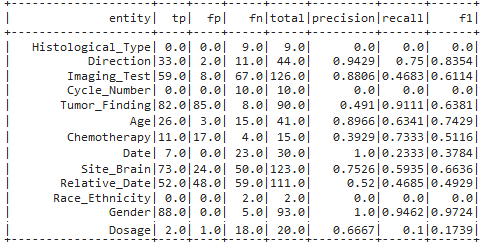

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import explode

In [ ]:
test_df_1 = test_set.withColumn("temp", F.arrays_zip("token", "label", "ner"))\
        .withColumn("temp", F.explode("temp"))\
        .select(F.col("temp.token.result").alias("token"), F.col("temp.label.result").alias("ground_truth"), F.col("temp.ner.result").alias("prediction"))\
        .toPandas()

test_df_1.tail(50)

,token,ground_truth,prediction
6357,",",O,O
6358,the,O,O
6359,patient's,O,O
6360,blood,O,O
6361,beta,B-Biomarker,O
6362,-,I-Biomarker,O
6363,HCG,I-Biomarker,O
6364,level,O,O
6365,was,O,O
6366,<2,B-Biomarker_Result,O


## **Load and Test the Trained Model on Sample Text**

Finally, the trained NER model is tested in a pipeline.

This involves loading the model and **applying it to new, unseen text** data to extract the entities.

This step enables to validate the **model's performance** and demonstrate its utility in real-world applications.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol( "document")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

trained_model = MedicalNerModel.load("models/brain_cancer")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner")

trained_model_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("model_chunk")\
    .setBlackList(['Gender'])

nlp_pipeline_cancer_types_model = Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_jsl,
        ner_jsl_converter,
        trained_model,
        trained_model_converter
        ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

nlp_model = nlp_pipeline_cancer_types_model.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


#### Sample Text

In [ ]:
text = """
A 55-year-old male patient, presented with progressive dizziness and gait disturbance for one month. Imaging examinations identified a mass measuring 25 mm in the right temporal
lobe. A surgical resection was performed. Upon microscopic examination, the tumor was found to consist of numerous small cells.
The tumor cells had scant cytoplasm, as “oat-like” or “lymphocyte-like”, and frequent mitoses could be observed (Fig. 1a). Additionally, there was a moderate proliferation of glial cells in the
surrounding tissue. A malignant small blue round cell tumor was
considered, and metastasis could not be ruled out. The immunohistochemistry showed that tumor cells were positive for CK, TTF-1,
synaptophysin, INSM1, p53, and were negative for vimentin, GFAP, Olig2, NeuN, CD3, and CD20 (Fig. 1bee). The Ki-67 index
was 80 %. Accordingly, lymphoma, glioma, and soft tissue tumors were dismissed, and metastatic SCLC was diagnosed, with further assistance of CT scanning.
During the evaluation of immunostaining, we noticed that NeuN was completely absent in surrounding brain tissues, in which glial cells were positive for GFAP and Olig2 (Fig. 1d and e).

In addition, despite the mild hypercellularity of glial cells, microcytic changes and perivascular pseudorosettes were evident focally (Fig. 1a).
These histological features are common diagnostic clues for the low-grade glioma. Therefore, we conducted further glioma-related genetic testing to exclude the presence of a low grade glioma.
To our surprise, the IDH1 R132H mutation (Fig. 1f) and MGMT promoter methylation were detected, and no other glioma-related gene alterations were detected, such as 1p/19q co-deletion, CDKN2A/B deletion,
TERT mutations, IDH2 mutations, etc. The IDH1 R132H mutation is the hallmark genetic alteration in the tumorigenesis of glioma, and is the most prevalent mutation
in glioma.2 Although IDH1 R132H can also be identified in other types of cancer such as acute myeloid leukemia and chondrosarcoma, to date, no reports have shown SCLC harboring this mutant.

The MGMT promoter methylation, a common genetic alteration in both SCLC and glioma, has no diagnostic roles but can serve as a predictive biomarker of benefit from temozolomide chemotherapy.
Based on the genetic and histological data, a diagnosis of astrocytoma, IDH-mutant, WHO grade 2, was confirmed. The final diagnosis was revised as an intracranial collision tumor of
low-grade astrocytoma and metastatic SCLC. According to the diagnosis, temozolomide was added to the chemo-radiotherapy strategy. The patient was followed up for nine months post-surgery without recurrence.

A 71 year male (BMI = 25 kg/m2) presented with chief complaint of weakness of left upper limbs and lower limbs for 22 days. He developed sudden weakness of left hand associated with numbness. He was unable
to hold weight in his left hand and was unaware of things slipping off his hand. Then, he developed weakness of his left foot and was unaware of slipping off his slipper. There was no history of abnormal body
movement, altered behavior and memory. He didn’t give history of trauma, headache, photophobia, slurring of speech, difficulty in swallowing. He did not give history of any prior comorbidities- diabetes mellitus,
hypertension and family history of any malignancies. On admission, his general condition was fair (GCS- E4V2M5). Bilateral pupils were 2 mm in diameter, and reactive to light. He was alert, conscious and well oriented to time, place, person. His vital signs
were stable and within normal limits. There was no pallor, icterus, lymphadenopathy, edema, dehydration, cyanosis or clubbing. There was weakness in his left upper and lower limbs (muscle power was 4/5
and 4/5 respectively). There was no weakness in his right upper and lower limb with muscle power 5/5. Bulk and tone of his upper and lower limbs were normal. There was decreased sensation in his left hand and
below left knee. However, sensations of right upper and lower limbs were intact. Bilateral plantar reflex was down going. His higher mental function and cranial nerves were normal. There was no facial deviation.
Cerebellar sign, meningeal irritation, clonus was absent. His heart sounds S1 and S2 were normal with no murmur. His breathing sounds were normal with no added sounds. The rest of the systemic examination
findings were regular.

Investigations such as hematological tests, Liver function tests (LFTs), Renal Function Tests (RFTs), Computed Tomography (CT) scan of head, Magnetic Resonance Imaging (MRI) of brain with Magnetic
Resonance Spectroscopy (MRS) were done. CT scan of head showed approximately 1.4 × 1.2 cm sized hyperdense extra-axial mass in right frontal cortex. A well-defined round solid cystic
lesion of 4x3cm is noted in the white matter of right parietal lobe. Areas of calcification and hemorrhage were absent. Perilesional edema was seen. Mass effect was noted in the form of effacement of adjacent sulci
and compression of body of right lateral ventricle. CT scan findings were suggestive of right frontal meningioma and right parietal malignant neoplastic lesion. MRI scan of brain with MRS
revealed solid cystic mass in front-parietal region with patchy diffusion restriction, tiny foci of blooming and patchy intense enhancement of solid component with perilesional edema and mild surrounding mass
effect with effacement of adjacent sulci- features suggestive of high-grade glioma. T1/T2 low and FLAIR high intense and homogenously enhancing lesion in right frontal parasagittal region-likely of meningioma.
"""

In [ ]:
light_model_model = LightPipeline(nlp_model)

light_result_model = light_model_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []
confidence = []

for n in light_result_model[0]['model_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    sentence.append(n.metadata['sentence'])
    confidence.append(n.metadata["confidence"])

df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end,
                   'sentence_id':sentence, 'entities':entities, 'confidence':confidence})

df_clinical

,chunks,begin,end,sentence_id,entities,confidence
0,month,95,99,0,Relative_Date,0.3327
1,Imaging,102,108,1,Imaging_Test,0.3462
2,mass,136,139,1,Tumor_Finding,0.4727
3,right,164,168,1,Direction,0.7728
4,temporal\nlobe,170,182,1,Site_Brain,0.28715
...,...,...,...,...,...,...
103,glioma,5444,5449,51,Tumor_Finding,0.1049
104,lesion,5512,5517,52,Tumor_Finding,0.4486
105,right,5522,5526,52,Direction,0.7719
106,frontal parasagittal,5528,5547,52,Site_Brain,0.3783


[**Spark NLP Display**](https://sparknlp.org/docs/en/display) is a utility in the Spark NLP library that provides visualization and debugging tools for NLP pipelines.

- Helps visualize the results of NLP annotations on text data.

- Shows detailed information about entities, relations, and other NLP features.

- Typically used after running a Spark NLP pipeline to inspect and validate results.

- Can generate HTML output for easy viewing in notebooks or browsers.

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result_model[0], label_col='model_chunk', document_col='document', save_path="display_result_text_1.html")